In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import StratifiedKFold
import csv
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.tree import export_graphviz
import graphviz
import sys
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import time
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('ignore', category=PerformanceWarning)

import sys
sys.path.append("../tools/")
from func import lgb_train_actual_irradiance, lgb_train_actual_power, xgb_train_actual_irradiance, xgb_train_actual_power
from data_preprocessing import data_preprocessing
from first_feature_engineering_pre import first_feature_engineering_wendu
from second_feature_engineering import second_feature_engineering
from specialize import specialize

In [2]:
# train_1 = pd.read_csv('../dataset/train_1.csv', encoding='GB18030') # length of train_1 is 66859
# train_2 = pd.read_csv('../dataset/train_2.csv', encoding='GB18030') # length of train_2 is 43755
# train_3 = pd.read_csv('../dataset/train_3.csv', encoding='GB18030') # length of train_3 is 29792
# train_4 = pd.read_csv('../dataset/train_4.csv', encoding='GB18030') # length of train_4 is 42687
# 将train_1划分为训练集和验证集，训练：严重的比例为4：1,将两个数据分别命名为train_1.csv和val_1.csv，保存在当前目录下

['month', '夜晚温度mean^2', '白天温度mean 夜晚温度mean', '白天温度mean^2', '温度mean 夜晚温度mean', '温度mean 白天温度mean', '温度mean^2', '夜晚温度std 夜晚温度mean', '夜晚温度std 白天温度mean', '夜晚温度std 温度mean', '夜晚温度std^2', '白天温度std 夜晚温度mean', '白天温度std 白天温度mean', '白天温度std 温度mean', '白天温度std 夜晚温度std', '白天温度std^2', '温度std 夜晚温度mean', '温度std 白天温度mean', '温度std 温度mean', '温度std 夜晚温度std', '温度std 白天温度std', '温度std^2', '夜晚温度差 夜晚温度mean', '夜晚温度差 白天温度mean', '夜晚温度差 温度mean', '夜晚温度差 夜晚温度std', '夜晚温度差 白天温度std', '夜晚温度差 温度std', '夜晚温度差^2', '白天温度差 夜晚温度mean', '白天温度差 白天温度mean', '白天温度差 温度mean', '白天温度差 夜晚温度std', '白天温度差 白天温度std', '白天温度差 温度std', '白天温度差 夜晚温度差', '白天温度差^2', '温度差 夜晚温度mean', '温度差 白天温度mean', '温度差 温度mean', '温度差 夜晚温度std', '温度差 白天温度std', '温度差 温度std', '温度差 夜晚温度差', '温度差 白天温度差', '温度差^2', '夜晚温度mean', '白天温度mean', '温度mean', '夜晚温度std', '白天温度std', '温度std', '夜晚温度差', '白天温度差', '温度差', '湿度^2', '压强 湿度', '压强^2', '温度 湿度', '温度 压强', '温度^2', '风向 湿度', '风向 压强', '风向 温度', '风向^2', '风速 湿度', '风速 压强', '风速 温度', '风速 风向', '风速^2', '辐照度 湿度', '辐照度 压强', '辐照度 温度', '辐照度 风向', '辐照度 风速', 

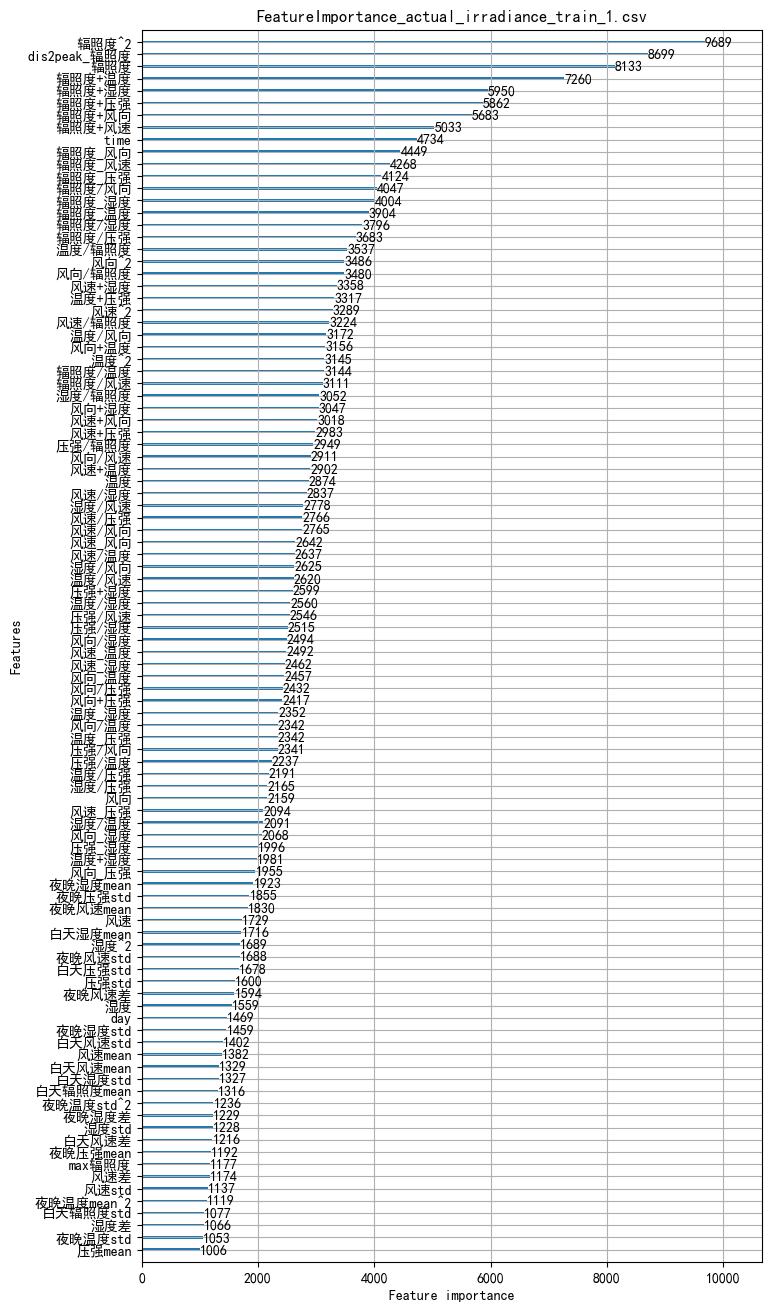

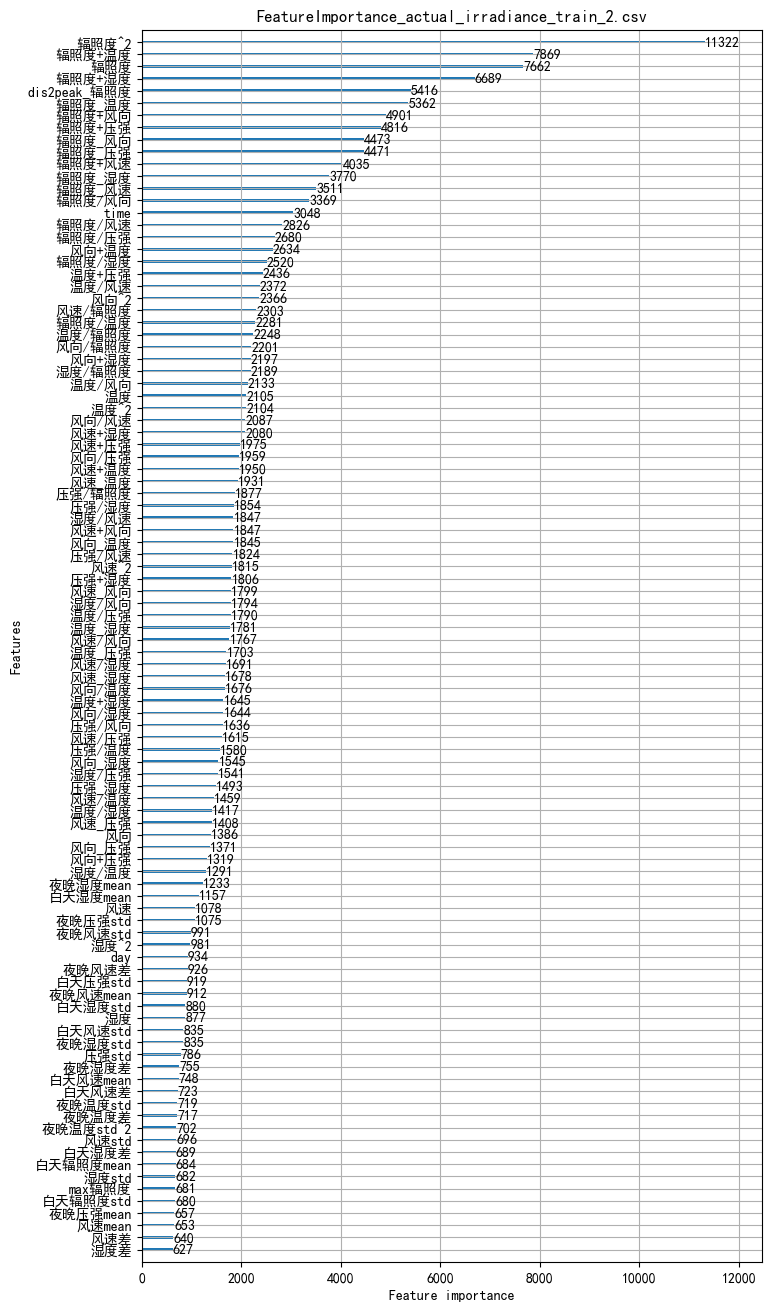

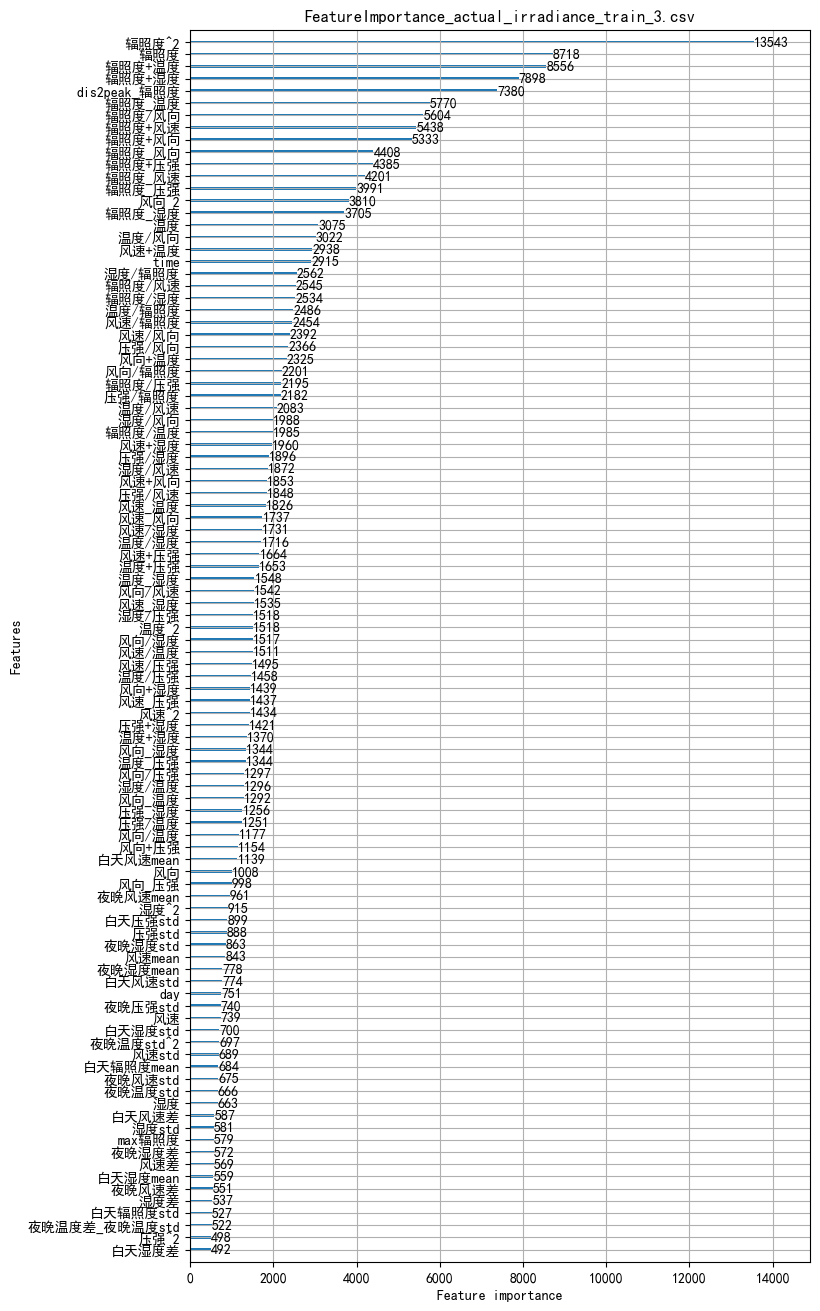

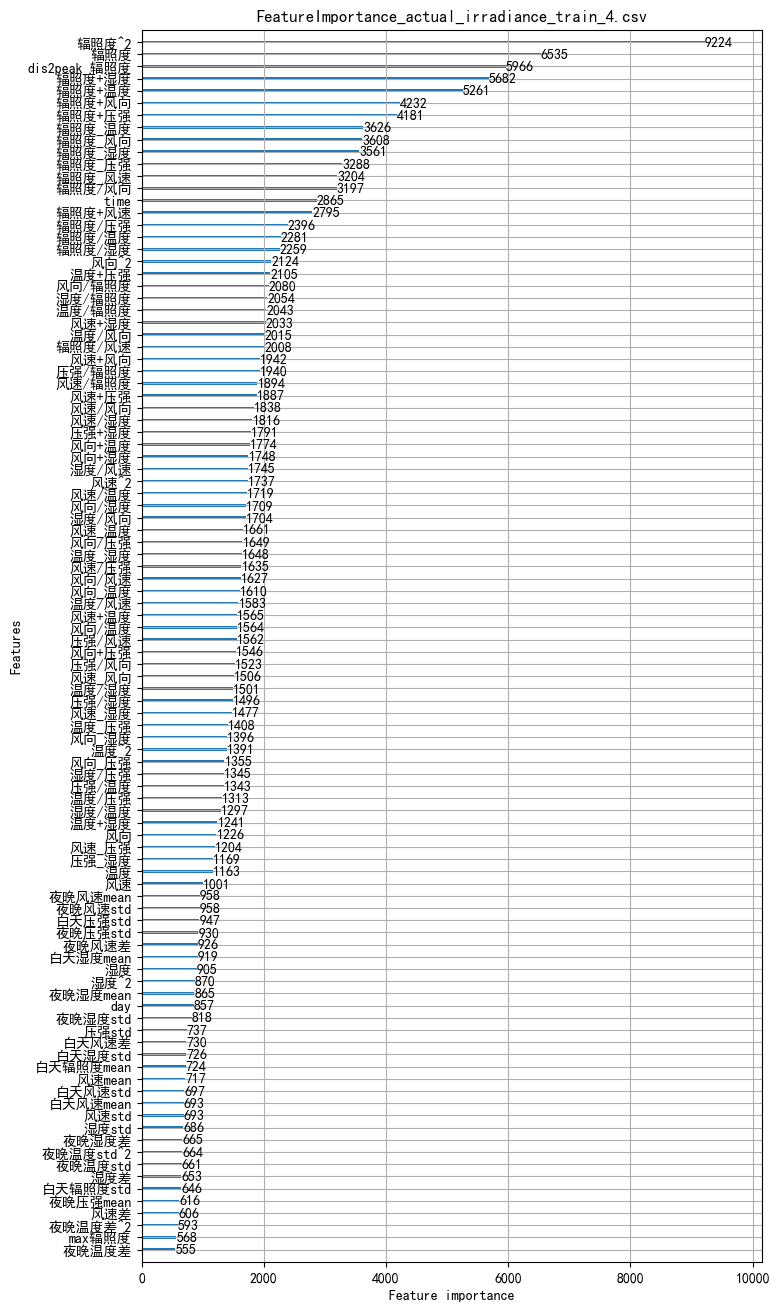

In [ ]:
if __name__ == '__main__':
    
    start_time = time.time()
    
    ### 常量设置
    path = 'D:/dissertation/dataset/raw_dataset/'
    prepared_path = 'D:/dissertation/dataset/prepared_dataset/'
    train_list = ['train_1.csv', 'train_2.csv', 'train_3.csv', 'train_4.csv']
    test_list = ['test_1.csv', 'test_2.csv', 'test_3.csv', 'test_4.csv']
    index_list = ['1', '2', '3', '4']
    experiment_time = '21'
    
    lgb_params = {
        "objective": "regression",
        "metric": "mse",
        "num_leaves": 50,
        "min_child_samples": 100,
        "learning_rate": 0.02,
        "bagging_fraction": 0.7,
        "feature_fraction": 0.5,
        "bagging_frequency": 5,
        "bagging_seed": 666,
        "verbosity": -1
    }
    
    xgb_params = {} #这里的参数在函数内部设置好了
    
    ### 对每个电场的数据依次进行训练
    for i in range(len(train_list)):
        
        ### 数据预处理
        train_old, test_old = data_preprocessing(path, train_list[i])
        ### 第一次训练的特征工程
        train_features, test_features, label_1, train_label, test_label, train_wendu, test_wendu = first_feature_engineering_wendu(train_old, test_old)
        
        ### 第一次训练 训练集和验证集划分
        X_train_1, X_validation_1, y_train_1, y_validation_1 = train_test_split(train_features, label_1, test_size=0.1, random_state=678)

        ### lgb第一次训练
        pred_label_1_lgb = lgb_train_actual_irradiance(X_train_1, y_train_1, X_validation_1, y_validation_1, test_features, lgb_params, ['实发辐照度'], experiment_time, train_list[i])
        
        # ### xgb第一次训练
        # pred_label_1_xgb = xgb_train_actual_irradiance(X_train_1, y_train_1, X_validation_1, y_validation_1, test_features, xgb_params, ['实发辐照度'], experiment_time, train_list[i])
        
        # pred_label = (pred_label_1_lgb + pred_label_1_xgb) / 2
        
        pred_label = pred_label_1_lgb
        
        ### 对lgb训练得到的结果（实发辐照度）作为新特征加入测试集特征
        train_features_new, test_features_new = second_feature_engineering(train_features, label_1, test_features, pred_label, train_old, test_old)
        
        train_data = pd.concat([train_features_new, train_wendu, train_label], axis=1)
        test_data  = pd.concat([test_features_new, test_wendu, test_label], axis=1)
        
        # 将train_features_new和test_features_new保存在'D:/dissertation/prepared_dataset/'下面，命名方式是train_{i}.csv和test_{i}.csv
        # 保存 train_features_new
        train_data.to_csv('D:/dissertation/dataset/pre_dataset/train_{i}.csv'.format(i=i+1), index=False)
        # 保存 test_features_new
        test_data.to_csv('D:/dissertation/dataset/pre_dataset/test_{i}.csv'.format(i=i+1), index=False)